In [ ]:
import os
import sys
import torch
import random 
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [ ]:
sys.path.append(os.path.abspath(os.path.join('..')))
from model.unit4 import DenoisingModelUnit4

In [3]:
random.seed(42)

In [ ]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

BATCH_SIZE = 32

raw_eeg = np.load('./eegdenoisenet/train_input.npy')
clean_eeg = np.load('./eegdenoisenet/train_output.npy')

artifact1 = np.load('./eegdenoisenet/EOG_all_epochs.npy')
artifact2 = np.load('./eegdenoisenet/EMG_all_epochs.npy')

test_input = np.load('./eegdenoisenet/test_input.npy')
test_output = np.load('./eegdenoisenet/test_output.npy')

artifact1 = standardization(artifact1)
artifact2 = standardization(artifact2)
artifact = np.concatenate((artifact1, artifact2), axis=0)

train_input = np.concatenate((raw_eeg, artifact, clean_eeg), axis=0)
train_output = np.concatenate((clean_eeg, artifact, clean_eeg), axis=0)

train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)

train_torch_dataset = Data.TensorDataset(train_input, train_output)

# Split into train and validation sets
val_ratio = 0.15
total_size = len(train_torch_dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

train_subset, val_subset = random_split(train_torch_dataset, [train_size, val_size])

train_loader = Data.DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = Data.DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_torch_dataset = Data.TensorDataset(test_input, test_output)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=1,
    shuffle=False,
)

In [5]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps=1e-6

    def forward(self,ground_truth,prediction):
        loss=torch.mean(torch.sqrt(torch.sum(torch.square(ground_truth-prediction), dim=-1))) + self.eps
        return loss

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingModelUnit4(1, 256, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = RMSELoss()
early_stopper = EarlyStopper(patience=5, min_delta=0.1)

os.makedirs('checkpoints/unit4_improved', exist_ok=True)

In [ ]:
writer = SummaryWriter()

num_epochs = 10
print("Starting Training...")
print(f"Training on device: {device}")
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    batch_count = 0
    for step, (train_input, train_output) in enumerate(train_loader):
        clean_eeg = train_output.float().to(device)  
        noisy_eeg = train_input.float().to(device)   
        
        
        clean_eeg = clean_eeg.unsqueeze(1)
        noisy_eeg = noisy_eeg.unsqueeze(1)
        
        optimizer.zero_grad()
        pred = model(noisy_eeg)
        train_loss = criterion(clean_eeg, pred)
        train_loss.backward()
        optimizer.step()
        
        running_loss += train_loss.item()

        if step % 50 == 0:
            writer.add_scalar('Loss/train_batch', train_loss.item(), epoch * len(train_loader) + step)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{step}/{len(train_loader)}], Loss: {train_loss.item():.6f}')
    
    avg_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)

    # Validation
    print("Validating for epoch:", epoch + 1)
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for step, (val_input, val_output) in enumerate(val_loader):
            clean_eeg = val_output.float().to(device)
            noisy_eeg = val_input.float().to(device)

            clean_eeg = clean_eeg.unsqueeze(1)
            noisy_eeg = noisy_eeg.unsqueeze(1)

            pred = model(noisy_eeg)
            loss = criterion(pred, clean_eeg)
            val_loss += loss.item()
            
            if step % 20 == 0:
                writer.add_scalar('Loss/val_batch', loss.item(), epoch * len(val_loader) + step) # Aug20_03-10-37_Zero, Aug22_03-12-46_Zero
    
    avg_val_loss = val_loss / len(val_loader)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning_Rate', current_lr, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.2e}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
        }
        torch.save(checkpoint, f'checkpoints/unit4_improved/checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}")
    
    if early_stopper.early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

# Save final model
torch.save(model.state_dict(), 'checkpoints/unit4_improved/final_normal_model.pth')
print("Training completed!")

writer.close()

Starting Training...
Training on device: cuda
Epoch [1/10], Batch [0/3427], Loss: 1010.005798
Epoch [1/10], Batch [50/3427], Loss: 189.716675
Epoch [1/10], Batch [100/3427], Loss: 122.103333
Epoch [1/10], Batch [150/3427], Loss: 85.822121
Epoch [1/10], Batch [200/3427], Loss: 68.184998
Epoch [1/10], Batch [250/3427], Loss: 55.139656
Epoch [1/10], Batch [300/3427], Loss: 45.052006
Epoch [1/10], Batch [350/3427], Loss: 39.381321
Epoch [1/10], Batch [400/3427], Loss: 34.534267
Epoch [1/10], Batch [450/3427], Loss: 31.441622
Epoch [1/10], Batch [500/3427], Loss: 28.449362
Epoch [1/10], Batch [550/3427], Loss: 28.247591
Epoch [1/10], Batch [600/3427], Loss: 25.816235
Epoch [1/10], Batch [650/3427], Loss: 23.146448
Epoch [1/10], Batch [700/3427], Loss: 21.601166
Epoch [1/10], Batch [750/3427], Loss: 21.954813
Epoch [1/10], Batch [800/3427], Loss: 21.598089
Epoch [1/10], Batch [850/3427], Loss: 21.096193
Epoch [1/10], Batch [900/3427], Loss: 18.285645
Epoch [1/10], Batch [950/3427], Loss: 17.

In [9]:
class Predictor:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def predict(self, noisy_eeg):
        with torch.no_grad():
            pred = self.model(noisy_eeg.float())
        return pred

In [ ]:
def plot(eeg_data, title):
    # Assuming eeg_data is a 1D numpy array
    sampling_frequency = 256  # Hz
    num_samples = len(eeg_data)
    time_duration = num_samples / sampling_frequency  # seconds
    time = np.linspace(0, time_duration, num_samples, endpoint=False) # Create a time vector

    plt.figure(figsize=(12, 5))
    plt.plot(time, eeg_data)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (arbitrary units, e.g., microvolts)')
    plt.grid(True)
    plt.show()

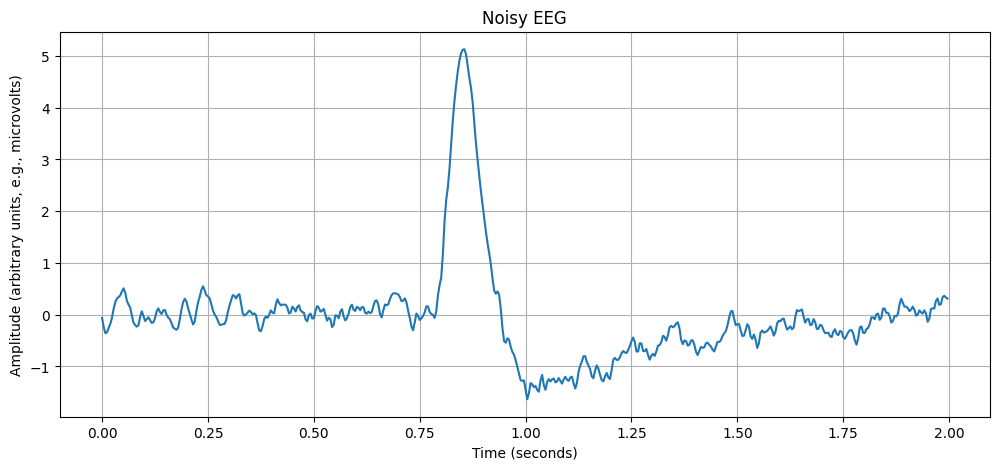

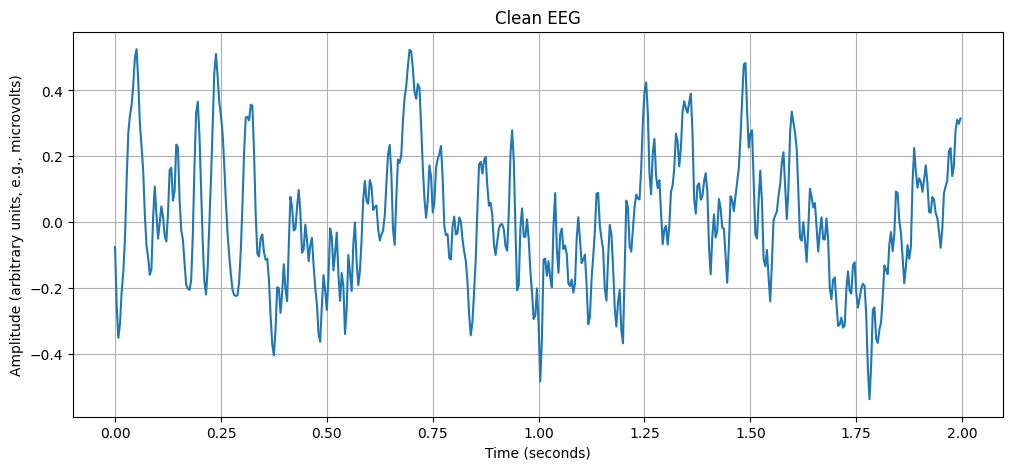

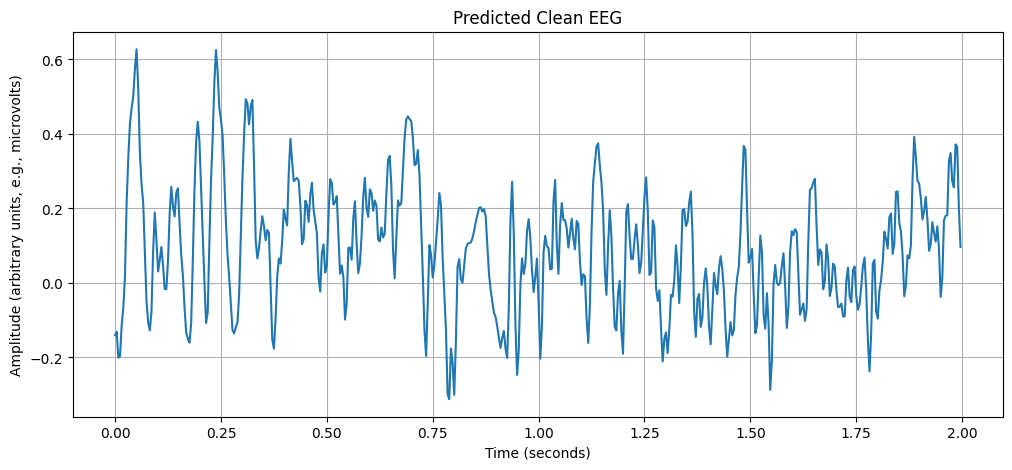

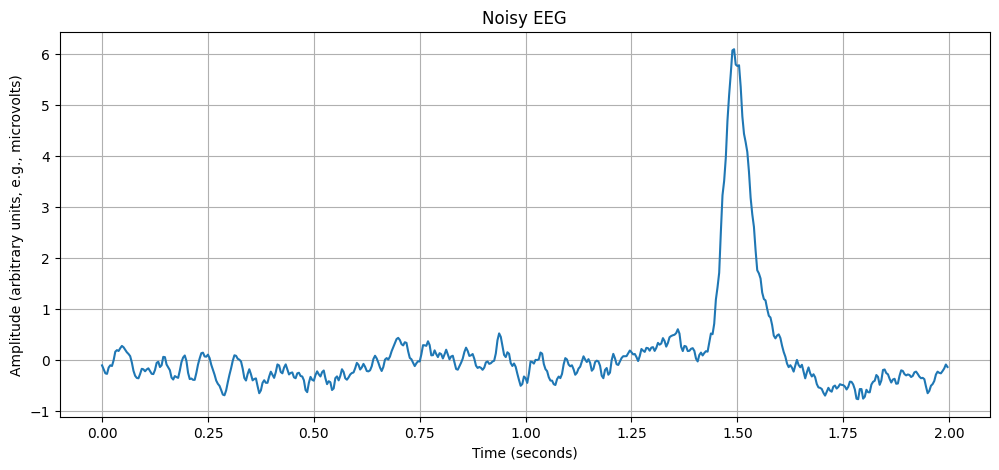

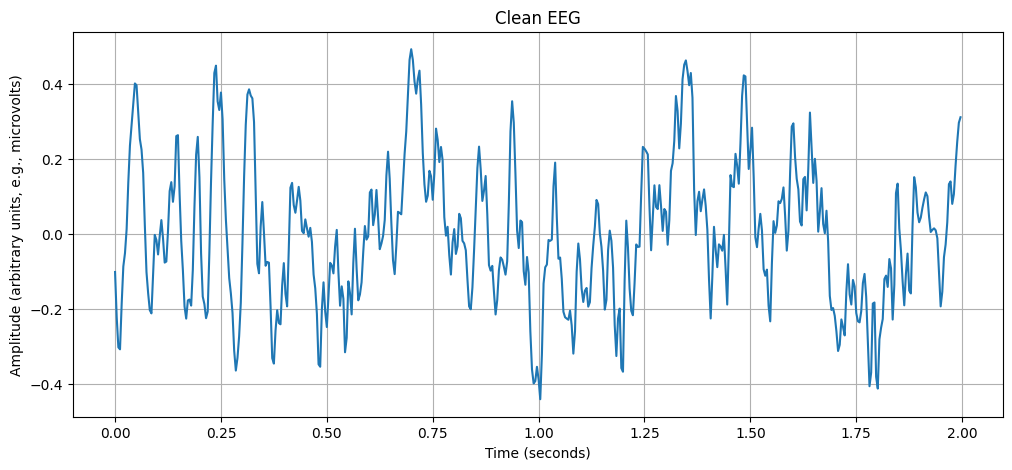

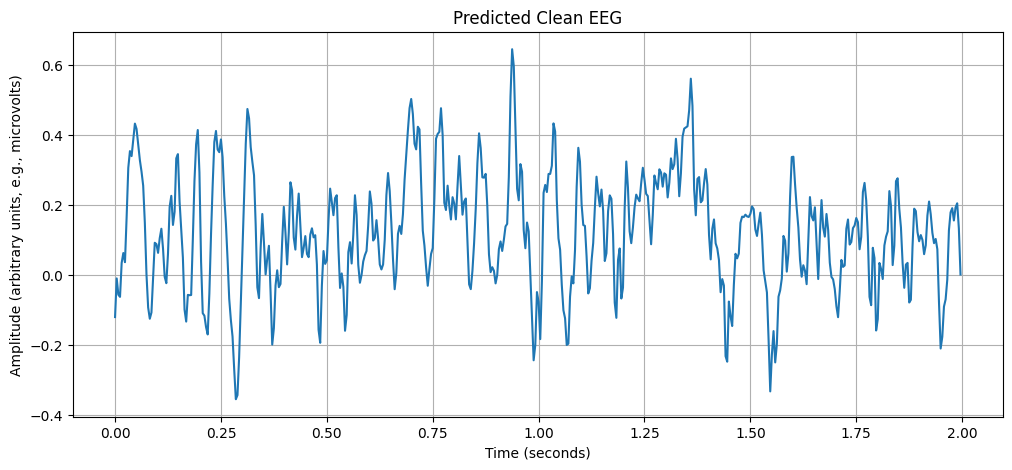

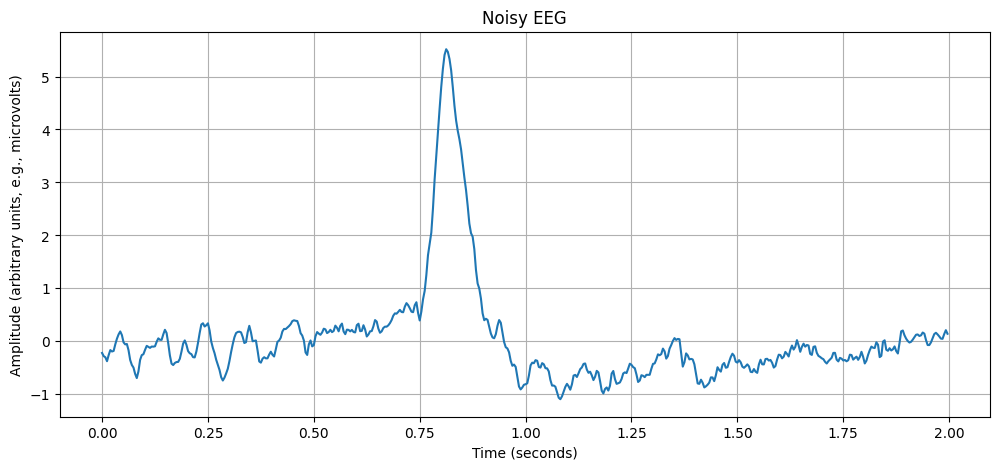

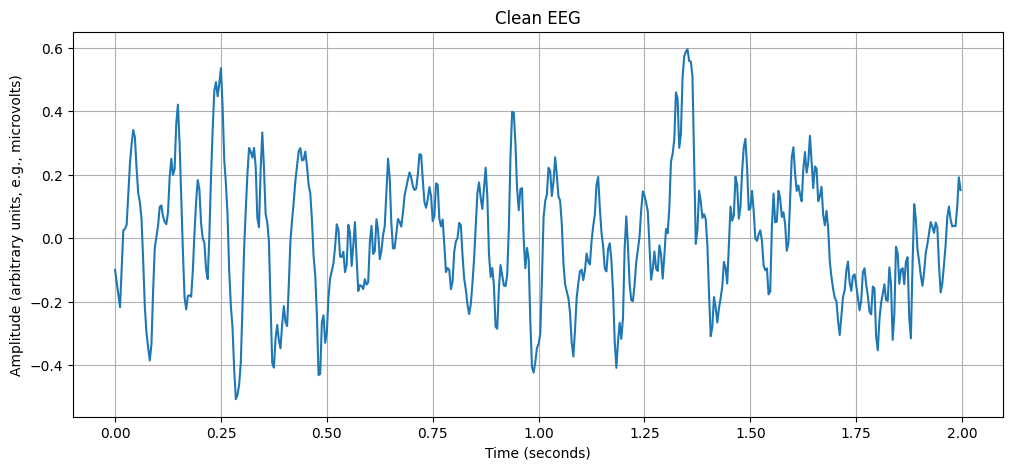

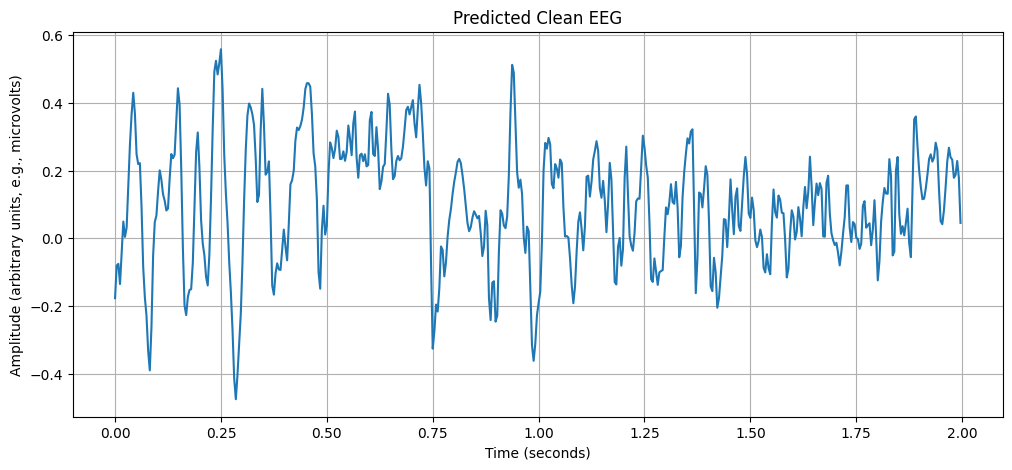

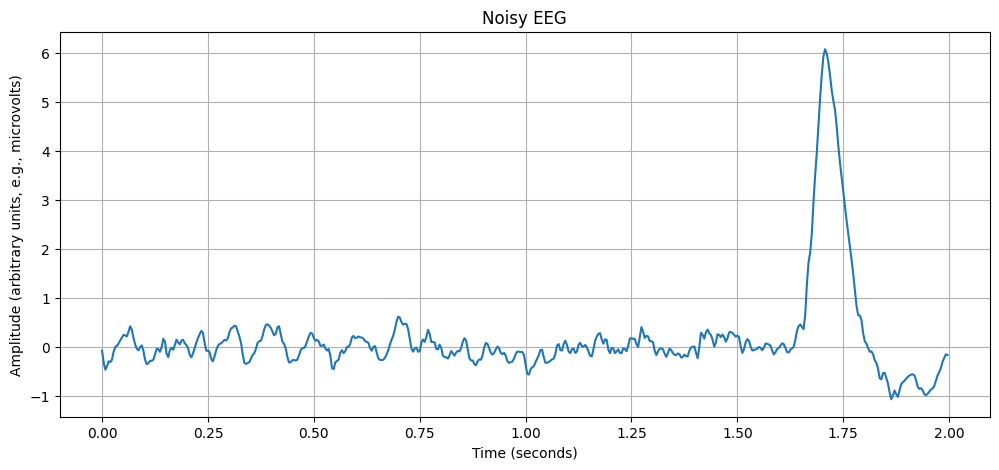

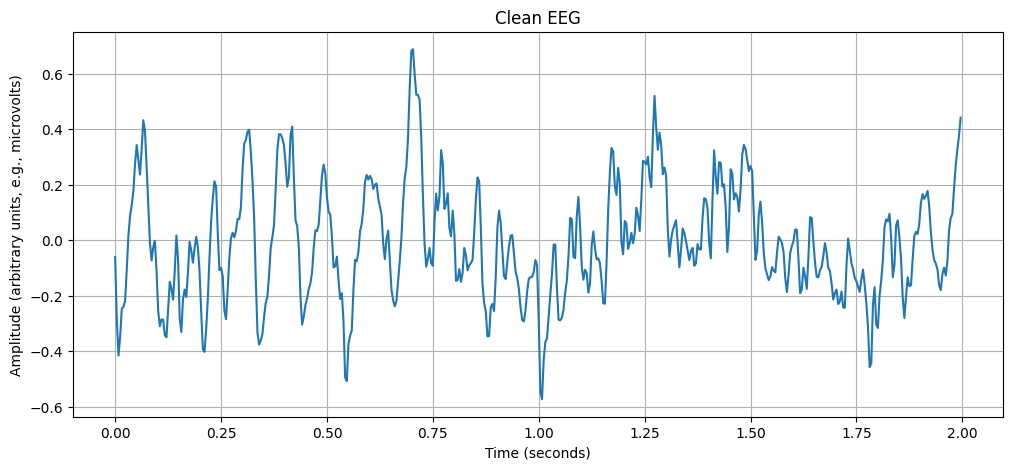

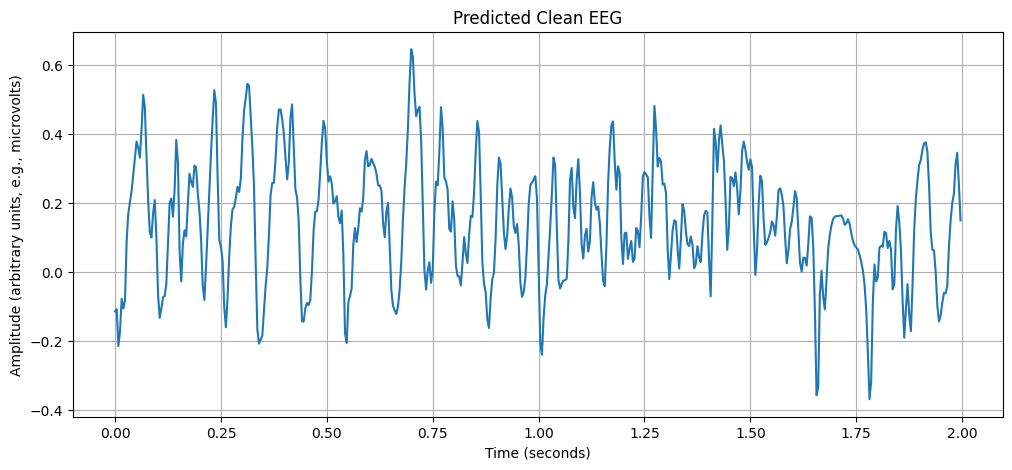

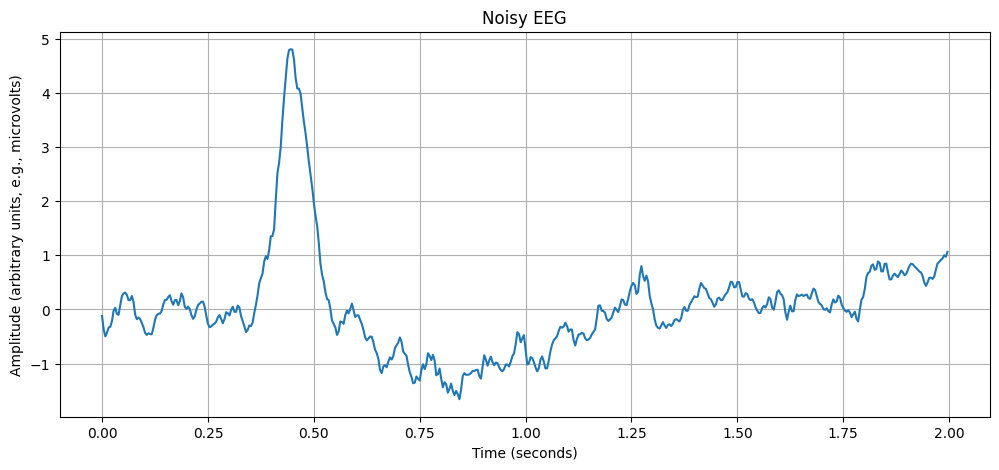

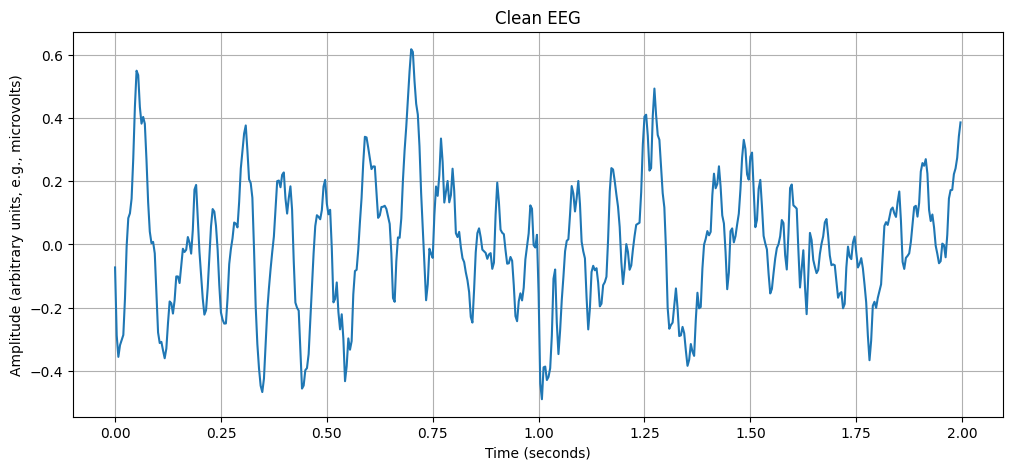

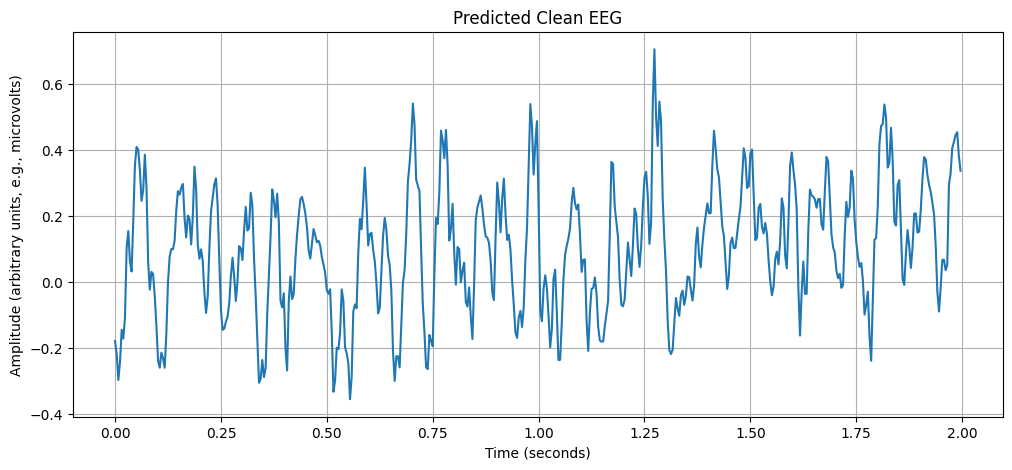

In [11]:
predictor = Predictor(model, device)
i = 0
for step, (test_input, test_output) in enumerate(test_loader):
    noisy_eeg = test_input.to(device)
    clean_eeg = test_output.float()
    pred_clean_eeg = predictor.predict(noisy_eeg.unsqueeze(1))
    plot(noisy_eeg[0].cpu().numpy(), "Noisy EEG")
    plot(clean_eeg[0].numpy(), "Clean EEG")
    plot(pred_clean_eeg[0][0].cpu().numpy(), "Predicted Clean EEG")

    i += 1
    if i == 5:
        break